# Introduction 

Dans ce fichier nous allons mettre en place une implémentation basique de l'algorithme proposé dans l'article à étudier.

Nous allons pour l'instant étudier le dataset Extended Yale B.

Les données sont présentes dans le dossier suivant : data/yale/

### TODO

* Pouvoir charger des images automatiquement à partir de l'id
* Reconstruction d'une image à partir des coefficients et comparaison à l'image originale.

# Imports 

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from PIL import Image
import os, sys
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import time

# Définition de fonctions utiles

Définition de la fonction delta_i, indicatrice de la classe i.

In [3]:
def delta(x,i,classs):
    '''
    fonction indicatrice de la classe i
    '''
    n,m = len(x),len(classs)
    
    if (n != m):
        print 'vectors of differents sizes, cannot operate delta'
        
    tmp = i*np.ones(n)-classs

    for k in range(n):
        if tmp[k]==0:
            tmp[k]=1
        else:
            tmp[k]=0 
            
    return tmp*x

In [4]:
a = [1,1,1,2,2,2,2,2,2,3,3,4,4,4,5]
b = [6,6,6,6,6,6,6,6,6,6,6,6,6,6,6]

print delta(b,4,a)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  6.  6.  6.  0.]


Définition de la fonction de résidu qui renvoie la classe minimisant l'erreur de reconstruction suivant la norme L2.

In [108]:
def residu(y,A,x,class_x):
    '''
    renvoie les residus pour chaque classe.
    '''
    k = np.max(class_x)+1
    r = np.zeros(k)
    
    for i in range(0,k):
        r[i] = np.linalg.norm(y - np.dot(A,delta(x,i,class_x)))
        
    return r

Définition de la fonction retournant l'indice de concentration (_Sparsity Concentration Index_)

In [118]:
def SCI(x,classs):
    '''
    @input
      - classs: classe de chaque training element.
      - x     : sparse coefficients
    '''
    
    k = len(set(classs)) # Nombre de classes différentes
    
    # Puis on retourne la valeur du SCI
    return (k*(1/np.linalg.norm(x,ord=1))*np.max([np.linalg.norm(delta(x,i,classs),ord=1) for i in range(k)]) - 1)/(k-1)
    

Utilitaire : trouver la classe d'un élément du test set pour le Yale Database

In [96]:
def find_class(i):
    return int(i)/12

Utilitaire : fonction pour charger les fichiers

In [7]:
def read_images(path, sz=None): 
    '''
    Chargement des données
    Si spécifiée, réduction de dimensions incluse
    '''
    c=0
    X,y = [], []
    for dirname , dirnames , filenames in os.walk(path):
        for subdirname in dirnames:
            subject_path = os.path.join(dirname , subdirname) 
            for filename in os.listdir(subject_path):
                try:
                    im = Image.open(os.path.join(subject_path , filename)) 
                    im = im.convert("L")
                    # resize to given size (if given)
                    if (sz is not None):
                        im = im.resize(sz, Image.NEAREST)     
                    X.append(np.asarray(im, dtype=np.uint8)) 
                    y.append(c)
                except IOError:
                    pass
                except:
                    print "Unexpected error:", sys.exc_info()[0] 
                    raise
            c = c+1
            print c
    return [X,y]

# Chargement des images 

In [8]:
X, y = read_images('data/CroppedYale', sz=(12,10))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38


Vérification qu'on a bien chargé les données des individus

In [9]:
len(X)

2470

Alright : on a bien chargé 585 images qui ont été fournies, par individu (note : les erreurs correspondent aux fichiers .info).

*Rappel* : 64 illuminations par personne.

## Réduction de dimensions 

La réduction de dimensions est déjà inclue dans le chargement des images.

De la même manière que dans l'article, nous réduisons la dimensions des images de ()

## Retraitement du dataset 

Nous allons dans un premier temps supprimer toutes les images "toutes noires" (premières images pour chaque individu.

In [10]:
X_new = []
y_new = []

for i in range(len(X)):
    if i%65!=0:
        X_new.append(X[i])
        y_new.append(y[i])

## Séparation du dataset en train et test 

A chaque personne sont associées 64 images stockées dans _X_new_ :

* 29 images "négatives" (ex : yaleB01_P00A**-**005E-10)
* 35 images "positives" (ex : yaleB01_P00A**+**050E-40)

_Note :_ Une bonne partie des images est quasiment illisible (très mauvaise luminosité)

Afin d'avoir un test set et un train set à peu près homogènes, on va prendre 12 images de test pour 52 images de train (~19% dans le test), soit :

* 5 images "négatives"
* 7 images "positives"

In [11]:
X_train, X_test = [], []
ytrain, ytest = [], []
indices_train, indices_test = [], []

for i in range(len(X_new)):
    if i%64==0:
        # On compute les indices des éléments à placer dans le test, ils sont différents pour chaque image.
        test1 = np.random.choice(28,5,replace=False)
        test2 = 29 + np.random.choice(28,7,replace=False)
    
    # On crée X_test et X_train
    if ((i%64 in test1) or (i%64 in test2)):
        X_test.append(X_new[i])
        ytest.append(y_new[i])
        indices_test.append(i)
    else:
        X_train.append(X_new[i])
        ytrain.append(y_new[i])
        indices_train.append(i)

## Manipulation des matrices

On déroule chaque image en un vecteur puis on les concatène.

In [12]:
X_toconcat_train = [np.reshape(e,(120,1)) for e in X_train]
X_toconcat_test = [np.reshape(e,(120,1)) for e in X_test]

In [13]:
Xtrain = np.concatenate(X_toconcat_train,axis=1)
Xtest = np.concatenate(X_toconcat_test,axis=1) # Liste des samples du test, concaténés en colonne.

Vérification qu'on a la bonne taille

In [14]:
print('Taille du nouveau dataset',Xtest.shape)

('Taille du nouveau dataset', (120, 456))


C'est ok !

# Implémentation de l'algorithme 1 

In [15]:
from sklearn.linear_model import Lasso

On voit dans la littérature que cela revient à traiter le problème Lasso.

D'abord on crée un vecteur d'$\alpha_i$ à tester avec Lasso.

Puisqu'on utilise la fonction Lasso il est nécessaire d'adapter nos $\alpha_i$ à la dimension de $y$.

In [27]:
alpha_vec = np.logspace(2,4,20)
alpha_vec = alpha_vec/(Xtest.shape[0])

Puis on utilise Lasso pour trouver la solution à notre problème.

In [28]:
#for i, alpha in enumerate(alpha_vec):

testval = 22

clf = Lasso(alpha=alpha_vec[4]) #on prend l'alpha courant
clf.fit(Xtrain,Xtest[:,testval])
x = clf.coef_

** Affichage des résultats **

In [29]:
print "Classe réelle: ", ytest[testval]
print "Classe prédite: ",np.argmin(residu(Xtest[:,testval],Xtrain,x,ytrain))
print "Rejection: ", SCI(x,ytrain)

Classe réelle:  1
Classe prédite:  1
Rejection:  0.102789502334


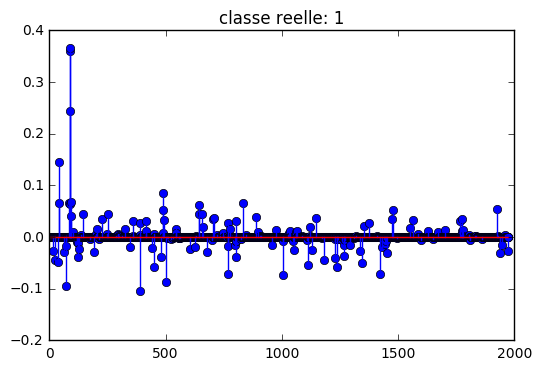

In [30]:
plt.figure()
plt.stem(x)
plt.title('Classe reelle: ' + str(ytest[testval]))

Avantage : meilleure interprétabilité des résultats : on sait où il y a des erreurs et pourquoi il y a des erreurs.

### Reconstruction de l'image

### Identification du meilleur lambda pour la régularisation, performance sans rejection

On va regarder la précision de notre algorithme pour différents lambda.

La métrique sera le _pourcentage de bonne classification_.

In [32]:
# Rappel : 
# * y : Elément à tester (est une colonne de Xtest)
# * Xtrain : Matrice A des exemples d'entrainement
# * x : coefficients issus de la minimisation LASSO
# * ytrain : classe des exemples d'entrainement

preds = np.zeros((len(alpha_vec),Xtest.shape[1]))
rejections = np.zeros((len(alpha_vec),Xtest.shape[1]))

for i, alpha in enumerate(alpha_vec):
    t = time.time()
    print "Coefficient de régularisation: ", alpha
    print "Boucle #",i+1,"/",len(alpha_vec)
    clf = Lasso(alpha=alpha) # on crée un modèle avec l'alpha courant
    for j in range(Xtest.shape[1]):
        # Pour chaque exemple à tester on génère les coefficients et on prend la meilleure prédiction
        y = Xtest[:,j]
        clf.fit(Xtrain,y)
        x = clf.coef_
        
        # On fait la prédiction
        preds[i,j] = np.argmin(residu(y,Xtrain,x,ytrain)) 
        rejections[i,j] = SCI(x,ytrain)
        
        # Affichage d'un message pour suivre l'avancement de l'algorithme
        
        if (j%50 == 0):
            print j, "exemples traités en",time.time() - t ,"s"
        
    print "Temps écoulé pour la boucle : ", time.time() - t

Coefficient de régularisation:  0.833333333333
Boucle # 1 / 20
0 exemples traités en 0.334184885025 s
50 exemples traités en 15.6089439392 s
100 exemples traités en 32.920017004 s
150 exemples traités en 50.8955528736 s
200 exemples traités en 67.6931447983 s
250 exemples traités en 84.2934668064 s
300 exemples traités en 100.988780022 s
350 exemples traités en 118.000137806 s
400 exemples traités en 134.923478842 s
450 exemples traités en 151.631476879 s
Temps écoulé pour la boucle :  153.494189024
Coefficient de régularisation:  1.06189582142
Boucle # 2 / 20
0 exemples traités en 0.303414821625 s
50 exemples traités en 16.9340109825 s
100 exemples traités en 33.4268088341 s
150 exemples traités en 50.1180138588 s
200 exemples traités en 66.5748548508 s
250 exemples traités en 83.4435229301 s
300 exemples traités en 99.9793608189 s
350 exemples traités en 116.600124836 s
400 exemples traités en 132.928030968 s
450 exemples traités en 154.342698812 s
Temps écoulé pour la boucle :  155.

On remarque que l'entrainement est spécialement long puisqu'on doit réentrainer un classifieur pour chaque exemple !

Mais c'est parallélisable

On calcule maintenant la précision pour chaque lambda

In [42]:
# Définition des classes réelles
real_classes = np.reshape(ytest*len(alpha_vec),(len(alpha_vec),len(ytest)))

# Evaluation de la précision

precision = 100.0*np.sum(preds == real_classes,axis=1)/len(ytest)

**Affichage des résultats**

[0, 20, 85, 95]

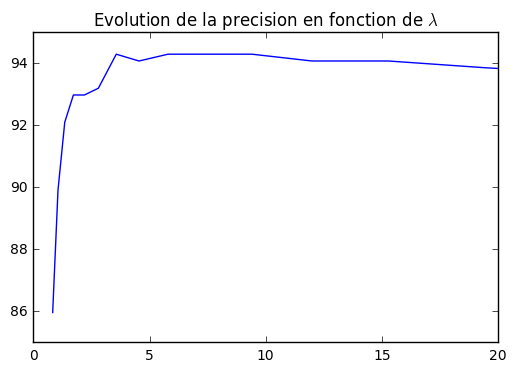

In [46]:
plt.figure()
plt.clf()
plt.plot(alpha_vec,precision)
plt.title('Evolution de la precision en fonction de $\lambda$')
plt.axis([0, 20, 85,95])

Détermination du coefficient optimal de régularisation

In [62]:
i_opt = np.argmax(precision)
alpha_opt = alpha_vec[i_opt]

In [123]:
# Coefficient optimal :  3.56777699893
print "Coefficient optimal : ", alpha_opt

Coefficient optimal :  3.56777699893


#### Etude des coefficients de rejection

In [64]:
wrong_preds = (rejections*(preds != real_classes))[i_opt,:]

Affichage des mauvaises prédictions

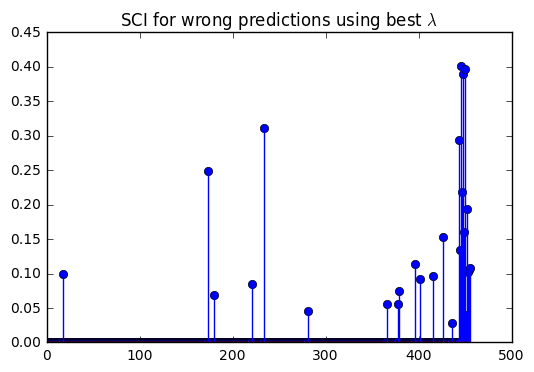

In [68]:
plt.figure()
plt.clf()
plt.stem(wrong_preds)
plt.title('SCI for wrong predictions using best $\lambda$')

On peut voir que la majorité des erreurs se trouve sur les derniers exemples, avec très peu d'erreur sur les premiers.

On a notamment constamment tort pour les 12 derniers exemples, appartenant tous à la même (la dernière) classe.
On se rend également compte qu'il ne s'agit pas d'une confusion avec une seule personne : les prédictions pour la dernière personne sont les suivantes : 
    [ 12.,  14.,  36.,  14.,  27.,   9., 27.,  17.,  22.,  17.,   8.,  19.].

In [78]:
wrong_preds[-50:]
preds[i_opt,-50:]

array([ 33.,  33.,  34.,  34.,  34.,  34.,  34.,  34.,  34.,   6.,  34.,
        34.,  34.,  34.,  35.,  35.,  35.,  35.,  35.,  35.,   4.,  35.,
        35.,  35.,  35.,  35.,  36.,  36.,  36.,  36.,  23.,  36.,  36.,
        36.,  36.,  36.,  36.,  36.,  12.,  14.,  36.,  14.,  27.,   9.,
        27.,  17.,  22.,  17.,   8.,  19.])

** Reclassement des coefficients de rejection par classe**

Rappel : 12 exemples par classes dans le test, 38 classes.

In [88]:
# Changer les coefficients dans zeros si changement de base.

rejec_by_class = np.zeros((12,38))

j = 0
for i in range(Xtest.shape[1]):
    if ((i%12 == 0) & (i != 0)):
        j = j+1
    rejec_by_class[i%12,j] = rejections[i_opt,i]

In [89]:
pd.DataFrame(rejec_by_class).describe()

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,...,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000
mean,0.243528,0.189966,0.212363,0.282957,0.212809,0.255240,0.281807,0.202025,0.240838,0.163296,...,0.222278,0.215757,0.210436,0.156597,0.236310,0.228954,0.182728,0.296736,0.324850,0.212092
std,0.116672,0.109344,0.092623,0.132177,0.090210,0.154864,0.148357,0.085100,0.140247,0.119284,...,0.114716,0.091770,0.136980,0.111412,0.149039,0.150680,0.106884,0.196066,0.187832,0.128217
min,0.108293,0.098795,0.097270,0.115612,0.126853,0.086041,0.095562,0.097141,0.056753,0.055652,...,0.092950,0.102719,0.056420,0.027204,0.072647,0.092808,0.078768,0.041258,0.028125,0.039849
25%,0.158071,0.117326,0.129043,0.185285,0.131561,0.104186,0.179792,0.135010,0.131953,0.077737,...,0.153069,0.148195,0.102678,0.071636,0.120058,0.136062,0.118100,0.143748,0.165851,0.107745
50%,0.228749,0.144080,0.204185,0.272431,0.181190,0.203457,0.262026,0.191680,0.200469,0.103077,...,0.187953,0.175713,0.174491,0.121313,0.180470,0.149841,0.150124,0.228281,0.369561,0.177477
75%,0.261951,0.215149,0.295807,0.405065,0.272317,0.390983,0.402450,0.253135,0.366298,0.248671,...,0.260691,0.299330,0.286940,0.241965,0.353663,0.275008,0.202589,0.499707,0.454454,0.317471
max,0.483980,0.433104,0.333337,0.471955,0.380116,0.489177,0.538617,0.352285,0.466583,0.378796,...,0.492597,0.381826,0.500556,0.390292,0.465498,0.523538,0.441493,0.536099,0.598011,0.400785


### Visualisation des résidus pour les exemples où l'algorithme se trompe

Choix de l'élément mal classifié #j à étudier

In [114]:
j = 2

Obtention des résidus

In [119]:
id_wrong_preds = np.where(preds[i_opt,:] != real_classes[i_opt,:])[0]
#for i in id_wrong_preds:
#    print find_class(i)

y = Xtest[:,id_wrong_preds[j]]
clf.fit(Xtrain,y)
x = clf.coef_

# On fait la prédiction
residus_cur = residu(y,Xtrain,x,ytrain)
rejections_cur = SCI(x,ytrain)

Affichage des résidus

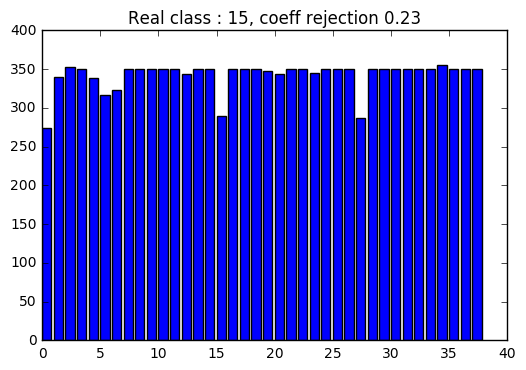

In [120]:
plt.figure()
plt.clf()
plt.bar(range(38),residus_cur)
plt.title('Real class : ' + str(find_class(id_wrong_preds[j])) + ', coeff rejection ' + str(np.round(rejections_cur,2)))

On peut observer les différents résidus pour les mauvais éléments en changeant la valeur de j. On voit que souvent (cas j = 2 par exemple), la vraie classe n'était pas très loin !

** Visualisation des images mal classifiées **

##### Partie utilisée pour sauvegarder les résultats des simulations

import pandas as pd

df_preds = pd.DataFrame(data=np.asarray(preds))
df_rejec = pd.DataFrame(data=np.asarray(rejections))

df_preds.to_csv('csv_saved/preds0.csv')
df_rejec.to_csv('csv_saved/rejec0.csv')